<img src="https://raw.githubusercontent.com/imedinam50/MCDI/main/MCDI.jpg">

<div style="text-align: right"> <H1> Proyecto final MCDI </H1></div>
<br><br><br>
<div style="text-align: right"> <H2> Asesor. Dr. Elio Atenógenes Villaseñor García </H2></div>
<br><br>

<H2>Ingeniería de datos</H2>
<br><br>
<H4><I> 
    Ismael Medina Muñoz
</I></H4>
<br>
<div style="text-align: right"> Fecha de entrega: 2022-0*-** </div>

# Introducción
## TODO

# Planteamiento del problema
La creación artística está siendo impactada por la inteligencia artificial. La música no es un campo ajeno a dicho impacto. La creación musical es un proceso que toma tiempo para el compositor. En un contexto de creación de obras artísticas usadas en productos como comerciales de productos, videojuegos, contenido audiovisual en internet, etc. se requiere de la producción acelerada.
Esta actividad de creación musical ha sido atribuida meramente a los humanos, tal cómo lo establece Morán Martinez, M (2009).

    La creación, la ejecución y la apreciación de la música obedecen fundamentalmente a la capacidad humana para descubrir patrones de sonido e identificarlos en ocasiones posteriores. Sin los procesos biológicos de percepción auditiva y sin consenso cultural sobre lo percibido, entre por lo menos algunos oyentes, no pueden existir ni música ni comunicación musical.

Si bien existen ya muchas investigaciones sobre la composición musical automatizada, la creación asistida e interactiva para los compositores es aún un reto para la investigación, tal como menciona Briot, J. (2021).

Para componer música necesitamos entonces de un generador de nuevas notas singulares o acordes basado en secuencias existentes, coherentes, pero principalmente consonantes, que ya sean parte de un corpus de entrenamiento.

En este proyecto se entrenará una red neuronal profunda para que sea un generador de un grupo de nuevas $n$-notas a un mismo tiempo a partir de dos vectores que representen secuencias de $n$-notas que ocurren a un mismo tiempo y cuya aparición en secuencia representaría grupos de $n$-notas que son consonantes. Este generador será un precursor a la asistencia en la composición de piezas de jazz para piano. Se escogió el género del jazz dado que éste representa un reto para los músicos por su complejidad y riqueza lingüística.

# Metodología propuesta y fundamentación
La composición musical consiste de crear secuencias de $n$-notas con $n = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}$ donde el silencio se representa por un conjunto de $0$-notas. Las $n$-notas ejecutadas en una secuencia $S$ deben ser agradables el oído humano, es decir, consonantes. Las partituras permiten registrar la música a través de escribir las $n$-notas colocadas en relación a su posición relativa en una secuencia $S$ dentro de los límites de un compás. Cada conjunto de $n$-notas tienen una duración que se mantienen bajo las reglas y límites propios de los compases.

La música es precursor del lenguaje hablado y por tanto mantiene una similitud con ésta, tal como establece Lozano(2013). Una oración sólo tiene coherencia si las palabras que la forman resultan en un significado para el receptor de la comunicación. Las oraciones forman párrafos y los signos de puntuación permiten agregar pausas y entonaciones que ayudan a que el cerebro del receptor consuma la información que el emisor pretendía.

Se escogió una fuente digital de partituras para modelar la secuencia $S$ de $n$-notas. El corpus provino entonces de __[musescore.com](https://musescore.com/)__. Desde este sitio se descargaron las partituras en formato **MSCZ** pertenecientes al género del jazz y de ahí se propone hacer la extracción de las $n$-notas asociadas al piano, ya que dichas partituras pueden tener más de un instrumento descrito en sus pentagramas.

Mediante la librería `ms3` se abrirán las partituras y de ellas se obtendrán las secuencias de $n$-notas asociadas al piano. Dichas $n$-notas ocurriendo en la misma posición de tiempo del compás se conocerán como rebanadas. Las secuencias de rebanadas de $n$-notas serán usadas para entrenar la red neuronal que predecirá la siguiente rebanada de $n$-notas en la secuencia. Este generador será el antecedente para la composición musical.

Este trabajo es similar al que ya se aplica para predecir la siguiente palabra o el siguiente número dada una secuencia previa y que ha sido modelado usando redes neuronales recurrentes (RNN).

Todos los conjuntos de datos intermedios en el procesamiento serán almacenados en archivos CSV dado el tiempo requerido para iterar el corpus y la capacidad que ofrece de segmentar el trabajo permitiendo retomar desde el paso último ejecutado.

# Implementación de la metodología
## Carga de librerías y las rutas del corpus

In [1]:
from ms3 import Score, Parse
import ms3
import os
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
mscx_path = '.\\sophisticated'

## Particularidades del corpus de partituras
Mediante la librería `ms3` se pueden abrir archivos de partituras del software libre MuseScore. La documentación de la librería está disponible en __[ms3 - Parsing MuseScore 3](https://johentsch.github.io/ms3/build/html/index.html)__. La herramienta MuseScore es un proyecto de comunidad que se define como una plataforma de creación de partituras y que además cuenta con un repositorio para que los compositores compartan las partituras creadas. Es de esta fuente que se descargaron 636 partituras en formato **MSCZ**. El contenido de los archivos es consumido mediante el objeto `Score` de la librería.

El objeto `Score` describe metadata de la partitura. La partitura se divide en partes (`Parts`). Cada parte describe los pentagramas (`Staves`) asociados a un instrumento (`Instrument`). Con dicha metadata entonces se puede extraer el conjunto de notas y silencios `notes_and_rests` para las partes que describen los pentagramas de un instrumento.

El conjunto de datos `notes_and_rests` es un Pandas DataFrame que describe una partitura a través de las siguientes columnas.

* **Measure Count (mc)**. La característica describe el compás actual donde la nota o el silencio están siendo descritos. Este indica el conteo de los compases aún si estos tuvieran notas en anacrusa. Este es un arreglo base 1.
* **Measure Number (mn)**. La característica describe el número de compás completo donde la nota o el silencio están siendo descritos. Este representa la manera en la que los humanos se refieren a la posición en una partitura. Este es un arreglo base 0.
* **Measure Number On Set (mn_onset)**. La característica describe la distancia de la posición solicitada desde el tiempo 1 del primer compás completo (mn) tomando en cuenta que esto puede estar en anacruza, expresada como fracción de una nota entera. El valor predeterminado es 0, es decir, la posición del tiempo 1.
* **Measure Count On Set (mc_onset)**. La característica describe la distancia de la posición solicitada desde el tiempo 1 del compás completo (mc), expresada como fracción de una nota entera. El valor predeterminado es 0, es decir, la posición del tiempo 1.
* **Time Signature (timesig)**. Tiempo del compás actual y de ahí los subsecuentes.
* **Staff (staff)**. Número del pentagrama en la partitura.
* **Voice (voice)**. Número de la voz del instrumento que ejecuta la partitura.
* **Duration (duration)**. Duración de la nota en cuestión
* **Tied (tied)**. Ligadura, esto indica que la nota está ligada hacia adelante (1) o hacia atrás (-1) con otras notas en la partitura.
* **MIDI (midi)**. Nota MIDI que debe ser ejecutada por la voz en una posición específica, con una duración específica, en un pentagrama específico y que puede tener ligaduras en la partitura.
* **Tonal pitch classes (tpc)**.
* **Chord ID (chord_id)**.

## Análisis Exploratorio de Datos
Para entender las partituras y las propiedades del objeto `Score` se hizo un análisis exploratorio de datos. A continuación se presentan los análisis.

### ¿Realmente se tocan hasta 5 notas por pentagrama en cada rebanada de tiempo?
La ejecución en piano dictaría que cada uno de los 2 pentagramas, uno en clave de Sol y otro en la clave de Fa, sólo podría describir 5 notas diferentes dada la disposición de la mano humana. Esto suma entonces las 10 notas que las manos humanas, en conjunto, podrían tocar.

Es importante identificar si para cada rebanada de tiempo tenemos la pulsación de 10 notas como máximo. Suponemos que cada conjunto de $n$-notas pulsadas en la misma posición relativa en el compás debe ser de 10 elementos cuando más. Comprobarlo serviría para remover estructuras que den información no factible a la red neuronal. El código siguiente permite analizar una partitura cada vez agrupando los dato por `Measure Number` para hacer una lectura similar a la humana considerando la anacrusa.

In [3]:
filename = "Keith_Jarrett_-_Danny_Boy__Londonderry_Air__Tokyo_Solo_2002.mscz"
##filename = "Roger Williams - Autumn leaves.mscz"

s = Score(mscx_path + '\\' + filename, read_only=True, logger_cfg = dict(level='CRITICAL'))

In [4]:
## Here the part of the piano instrument and the staves are retrieved
## Parts respond to different instruments with their staves
parts_staves = []
for part in s.mscx.metadata['parts']:
    ## We filter only those piano parts
    if s.mscx.metadata['parts'][part]['instrument'] == 'Piano':
        ## Each part can have one or more staves. The piano will usually have 2.
        ## The one in the clef of G (right hand) and the one in the clef of FA (left hand)
        staves = s.mscx.metadata['parts'][part]['staves']
        parts_staves.append([part, staves])
        print("'Piano' part names:", part, ". Stave Id's:", staves)

## In this dataframe we are going to accumulate the count of notes pressed at the same time for each slice of time
n_notes_count = pd.DataFrame(columns=['filename', 'part', 'staff', 'time_signature', 'count_n_notes'])
max_midi = 0

parts_notes_rests = s.mscx.notes_and_rests()

for part, staves in parts_staves:
    ## Filter staves for one part at a time
    part_notes_rests = parts_notes_rests[parts_notes_rests['staff'].isin(staves)]

    ## Rests are also counted, but we only want to see the notes held
    part_notes_rests = part_notes_rests[part_notes_rests.midi > 0]
    
    ## We group by slice of time in each bar on each staff
    slices_n_notes = part_notes_rests.groupby(by=["mc", "mc_onset", "staff", "timesig"])
    
    ## We iterate and store the count of n-notes per time slice and per staff
    for key, row in slices_n_notes.count().iterrows():
        n_notes_count.loc[len(n_notes_count.index)] = [filename, part, key[2], key[3], row.mn]

'Piano' part names: part_1 . Stave Id's: [1]
'Piano' part names: part_2 . Stave Id's: [2]


In [5]:
n_notes_count.head(10)

,filename,part,staff,time_signature,count_n_notes
0,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,1
1,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,2
2,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,2
3,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,3
4,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,2
5,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,1
6,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,2
7,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,1
8,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,2
9,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,1


In [6]:
n_notes_count.to_csv('.\\data\\n_notes_count.csv')

In [7]:
n_notes_count = pd.read_csv('.\\data\\n_notes_count.csv', index_col = 0)

In [8]:
n_notes_count.head(10)

,filename,part,staff,time_signature,count_n_notes
0,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,1
1,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,2
2,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,2
3,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,3
4,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,2
5,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,1
6,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,2
7,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,1
8,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,2
9,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,1


### Gráfica de la cantidad de notas pulsadas en los pentagramas en cada rebanada de tiempo por métrica del compás
Es notoria que la mayoría de $n$-notas se describen como $1$-notas, $2$-notas y $3$-notas. Existen pocas combinaciones de $4$-notas e incluso hay unas pocas $6$-notas. No existen casos de $5$-notas en la partitura elegida. El caso de $6$-notas es interesante dado que esperariamos que no existieran este tipo de pulsaciones. Esta partitura tiene compases definidos con tiempos muy variados. Regularmente en el jazz clásico tendremos el ritmo de vals ($ \frac {3} {4} $), el blues ($ \frac {12} {8} $) y el tiempo de ($ \frac {4} {4} $) donde se pueden representar otros tipos de ritmos.

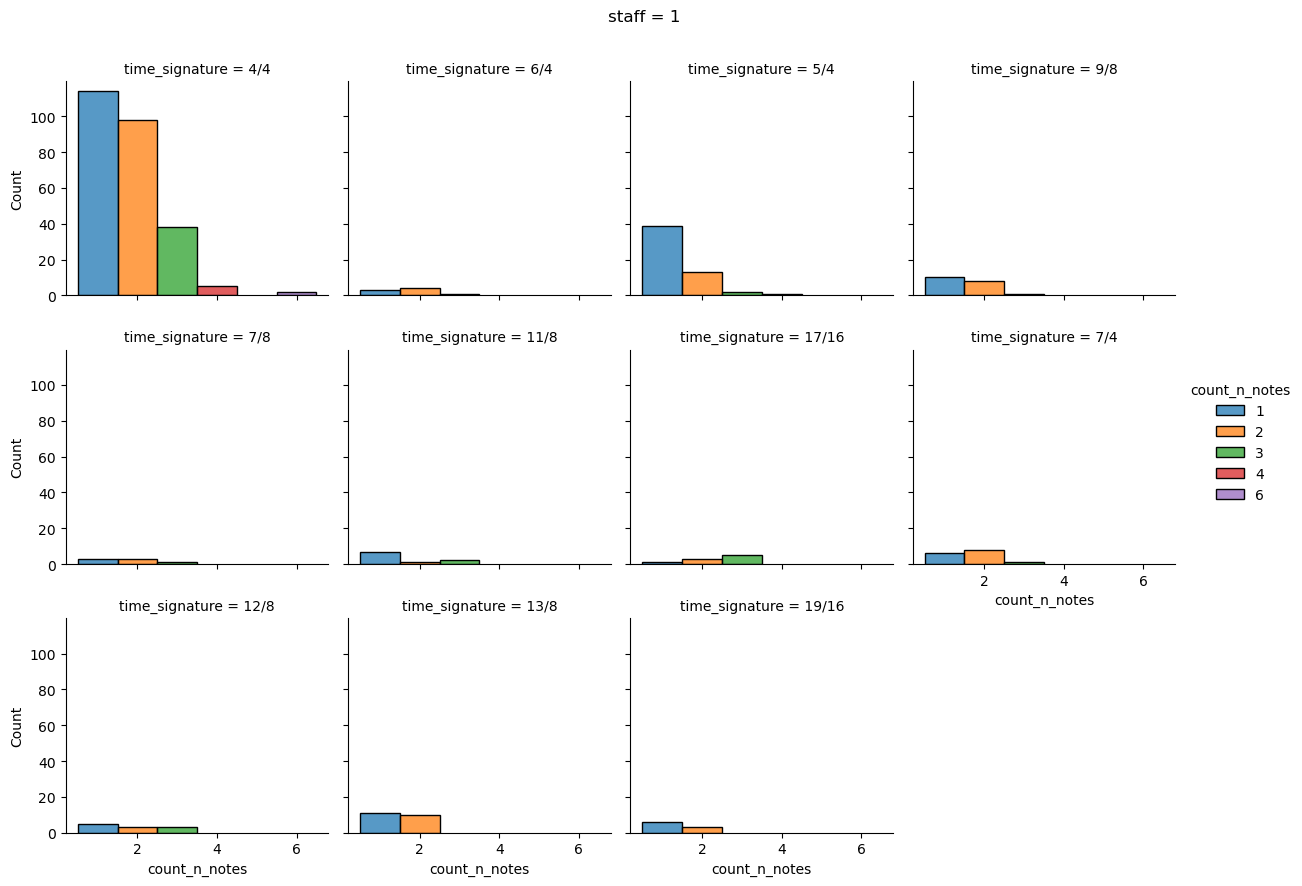

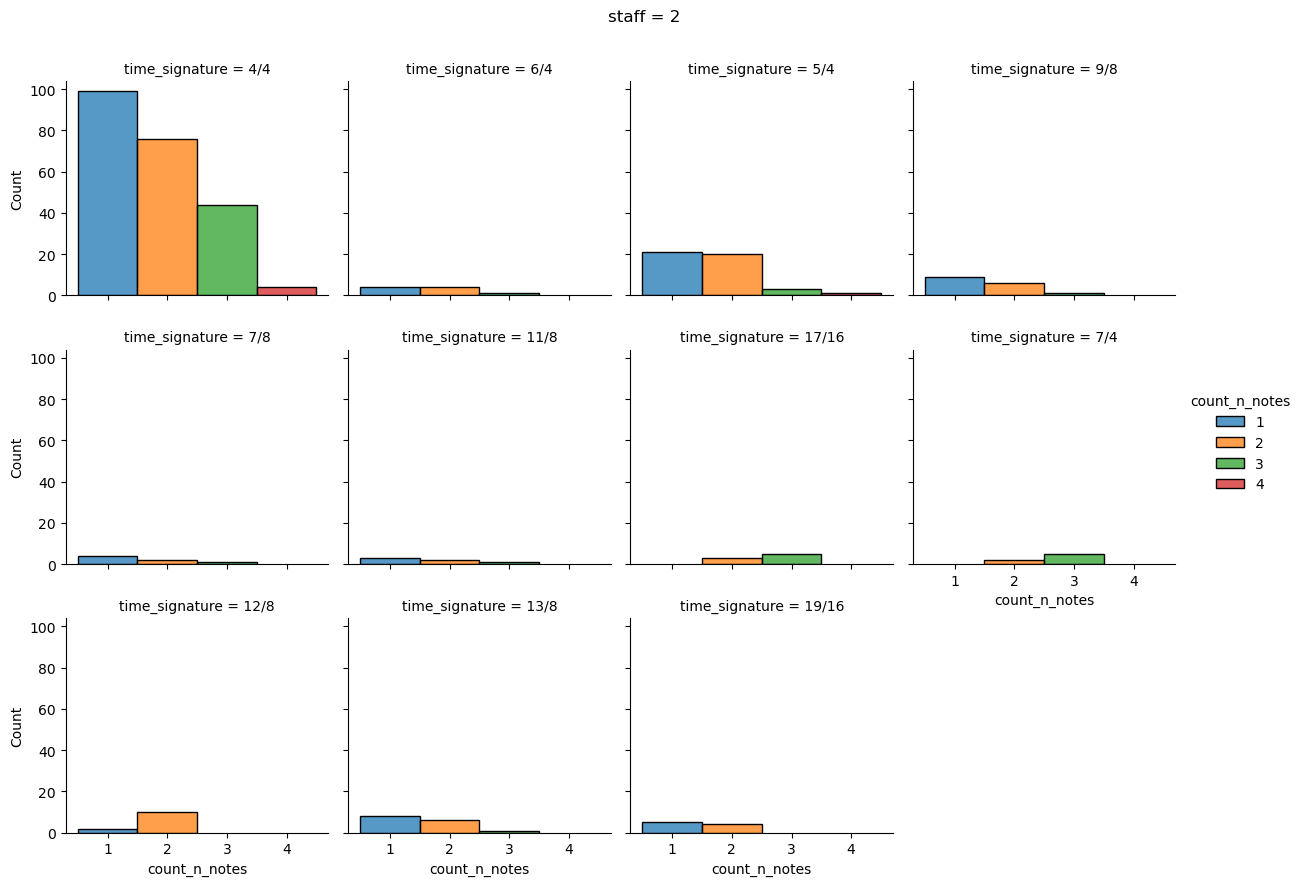

In [9]:
for staff in n_notes_count.staff.unique():
    g = sns.FacetGrid(data=n_notes_count[n_notes_count.staff==staff], col='time_signature', col_wrap=4, 
                      hue = 'count_n_notes', margin_titles=True)

    #add histograms to each plot
    g.map(sns.histplot, 'count_n_notes')
    g.add_legend()
    g.fig.subplots_adjust(top = 0.9)
    g.fig.suptitle(f"staff = {staff}")


### Gráfica del rango de las notas en cada pentagrama
Es notoria que las $n$-notas de los pentagramas del piano parecen dividirse en 2. Esto nos lo indica el rango mínimo y máximo de la nota MIDI pulsada. Es notorio que para uno de los pentagramas las notas son bajas y tienen un límite que está en sobreposición con las notas en el pentagrama subsecuente.

In [10]:
## Here the part of the piano instrument and the staves are retrieved
## Parts respond to different instruments with their staves
parts_staves = []
for part in s.mscx.metadata['parts']:
    ## We filter only those piano parts
    if s.mscx.metadata['parts'][part]['instrument'] == 'Piano':
        ## Each part can have one or more staves. The piano will usually have 2.
        ## The one in the clef of G (right hand) and the one in the clef of FA (left hand)
        staves = s.mscx.metadata['parts'][part]['staves']
        parts_staves.append([part, staves])
        print("'Piano' part names:", part, ". Stave Id's:", staves)

## In this dataframe we are going to accumulate the count of notes pressed at the same time for each slice of time
n_notes_midi_range = pd.DataFrame(columns=['filename', 'part', 'staff', 'midi'])
max_midi = 0

parts_notes_rests = s.mscx.notes_and_rests()

for part, staves in parts_staves:
    ## Filter staves for one part at a time
    part_notes_rests = parts_notes_rests[parts_notes_rests['staff'].isin(staves)]

    ## Rests are also counted, but we only want to see the notes held
    part_notes_rests = part_notes_rests[part_notes_rests.midi > 0]
    
    ## We group by slice of time in each bar on each staff
    slices_n_notes = part_notes_rests[['staff', 'midi']]
    
    ## We iterate and store the count of n-notes per time slice and per staff
    for key, row in slices_n_notes.iterrows():
        n_notes_midi_range.loc[len(n_notes_midi_range.index)] = [filename, part, row.staff, row.midi]

'Piano' part names: part_1 . Stave Id's: [1]
'Piano' part names: part_2 . Stave Id's: [2]


In [11]:
n_notes_midi_range.head(10)

,filename,part,staff,midi
0,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,64
1,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,62
2,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,65
3,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,61
4,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,67
5,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,57
6,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,64
7,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,69
8,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,57
9,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,62


In [12]:
n_notes_midi_range.to_csv('.\\data\\n_notes_midi_range.csv')

In [13]:
n_notes_midi_range = pd.read_csv('.\\data\\n_notes_midi_range.csv', index_col = 0)

In [14]:
n_notes_midi_range.sort_values(by='midi').head(10)

,filename,part,staff,midi
1326,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,33
1327,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,34
1252,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,37
1256,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,38
1254,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,38
1009,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,38
1323,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,41
1319,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,41
1329,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,41
1330,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,41


In [15]:
n_notes_midi_range[n_notes_midi_range.staff == 1]

,filename,part,staff,midi
0,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,64
1,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,62
2,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,65
3,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,61
4,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,67
...,...,...,...,...
706,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,57
707,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,65
708,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,72
709,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,81


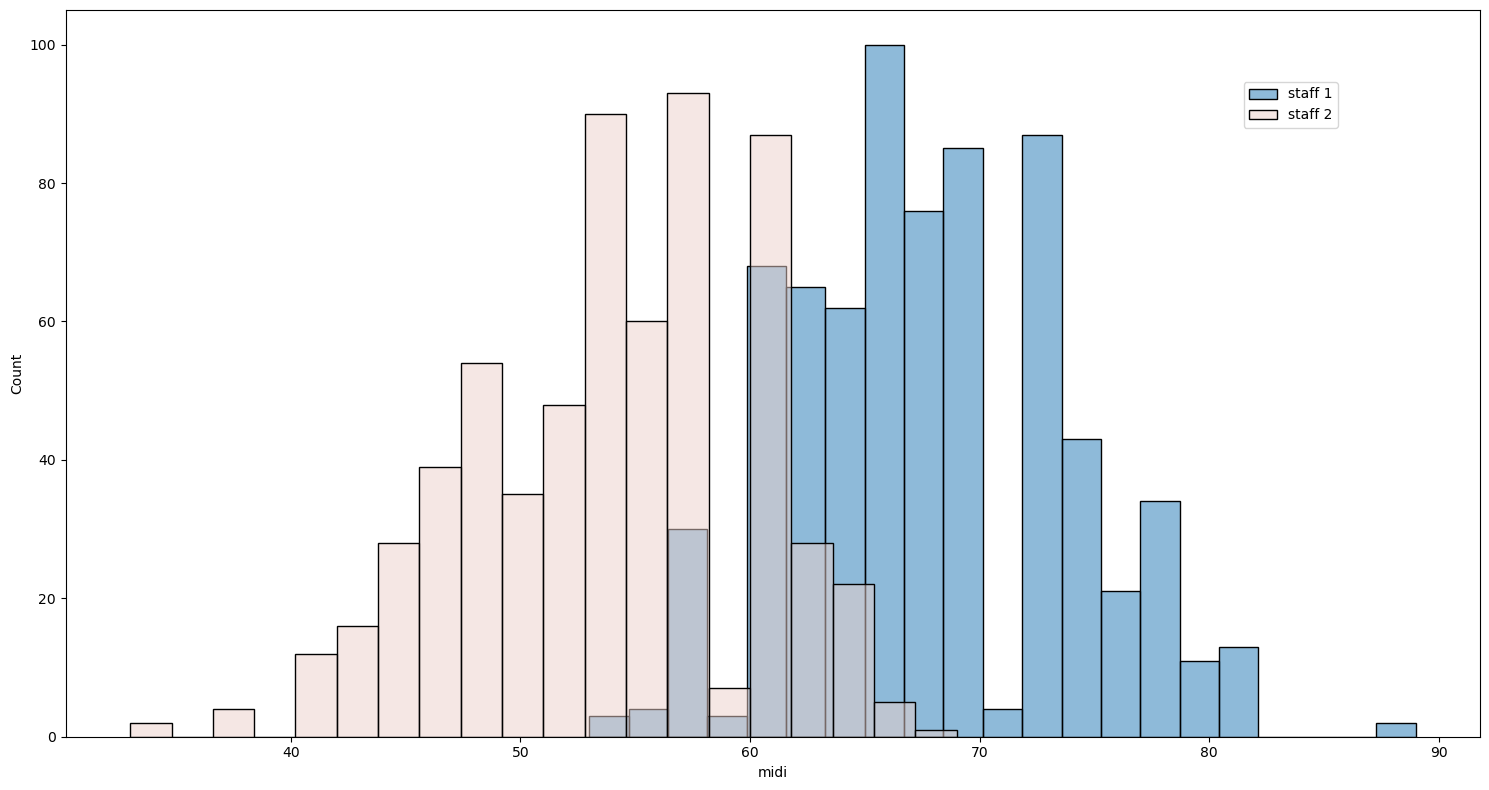

In [16]:
columnas = 1
renglones = 1

fig, axes = plt.subplots(nrows = renglones, ncols = columnas, figsize=(15, 8))
##fig.suptitle("Range of MIDI Values by Staff", fontsize = 16)

for staff in n_notes_midi_range.staff.unique():
    n_notes_midi_range_staff = n_notes_midi_range[n_notes_midi_range.staff == staff]
    sns.histplot(data = n_notes_midi_range_staff,
                 x = 'midi', label = f"staff {staff}", hue = 'staff', legend = False)

fig.legend(bbox_to_anchor=(0.9, 0.9))  
fig.tight_layout()  

### Gráfica de la cantidad de notas pulsadas en los pentagramas en cada rebanada de tiempo
Es notoria que la mayoría de $n$-notas se describen como $1$-notas, $2$-notas y $3$-notas. Existen pocas combinaciones de $4$-notas e incluso hay unas pocas $6$-notas. No existen casos de $5$-notas en la partitura elegida. El caso de $6$-notas es interesante dado que esperariamos que no existieran este tipo de pulsaciones.

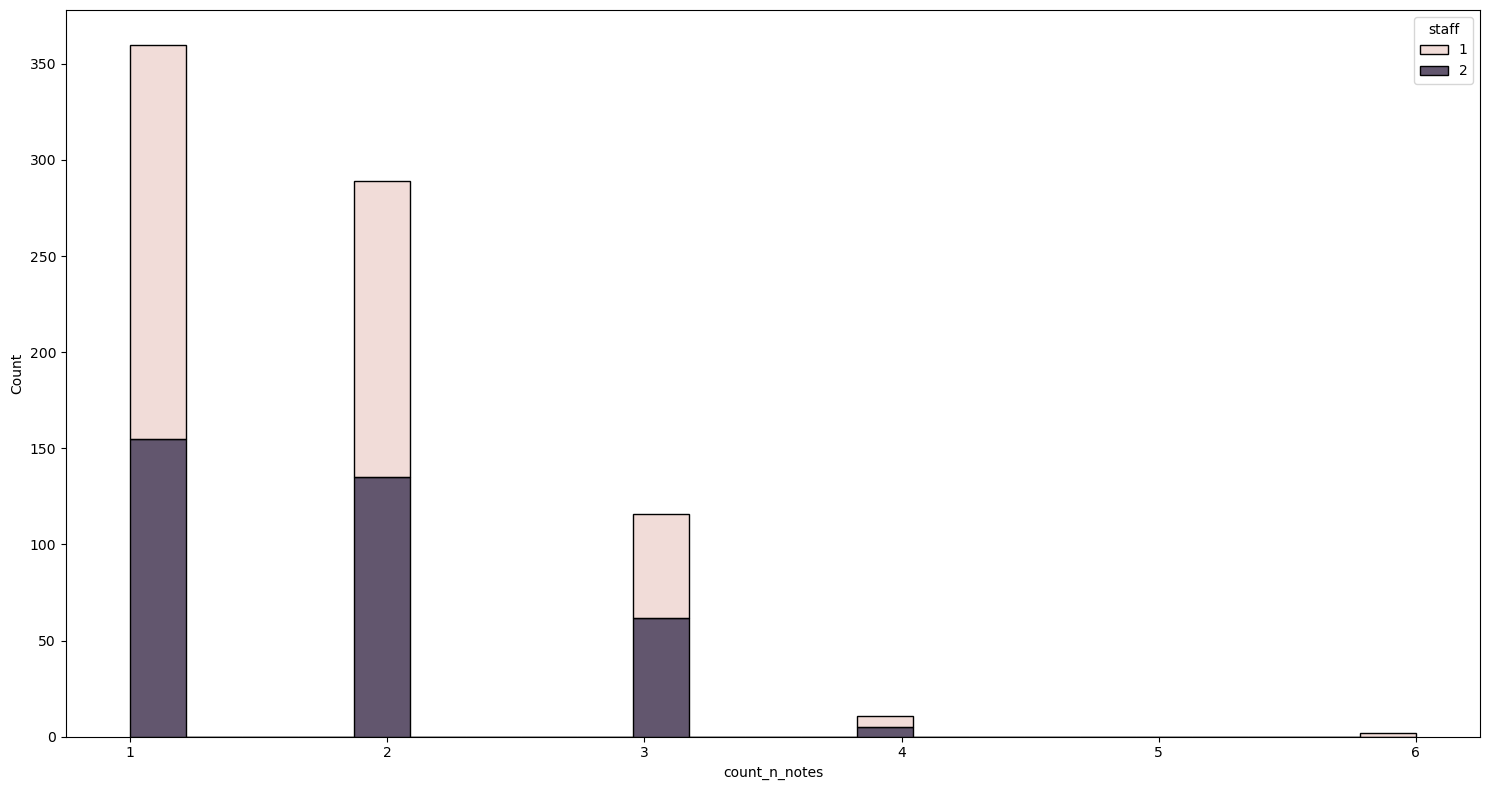

In [17]:
columnas = 1
renglones = 1

fig, axes = plt.subplots(nrows = renglones, ncols = columnas, figsize=(15, 8))
##fig.suptitle("Histogram for 'n-notes' per staves", fontsize = 16)

i = 0
j = 0
    
##for col in column_names:
sns.histplot(data = n_notes_count,
             x = 'count_n_notes',
             hue = 'staff',
             multiple='stack')

fig.tight_layout()  

### Estadísticas de las duraciones de las notas
Para un trabajo posterior a desarrollar, resulta de interés el obtener las duraciones de las notas que conformarán el dataframe de las rebanadas de $n$-notas.

In [18]:
from fractions import Fraction

mn_onset_count = pd.DataFrame(columns=['filename', 'part',
                                  'staff', 'duration', 'n_note_count'])

from fractions import Fraction

parts_notes_rests = s.mscx.notes_and_rests()

try:
    for part, staves in parts_staves:
        ## Filter staves for one part at a time
        part_notes_rests = parts_notes_rests[parts_notes_rests['staff'].isin(staves)]

        ## Rests are also counted, but we only want to see the notes held
        part_notes_rests = part_notes_rests[part_notes_rests.midi > 0]

        mn_onsets = part_notes_rests.groupby(by = ['staff', 'duration'])
        
        for key, row in mn_onsets.count().iterrows():
            mn_onset_count.loc[len(mn_onset_count.index)] = [filename, part, key[0], key[1], row.mn]
except:
    print('!', end = '')

In [19]:
mn_onset_count.to_csv('.\\data\\mn_onset_count.csv')

In [20]:
mn_onset_count = pd.read_csv('.\\data\\mn_onset_count.csv', index_col = 0)

In [21]:
mn_onset_count.head(10)

,filename,part,staff,duration,n_note_count
0,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,0,2
1,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,1/24,4
2,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,1/16,96
3,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,1/12,32
4,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,3/32,2
5,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,1/8,317
6,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,3/16,41
7,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,1/4,141
8,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,3/8,32
9,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,1/2,27


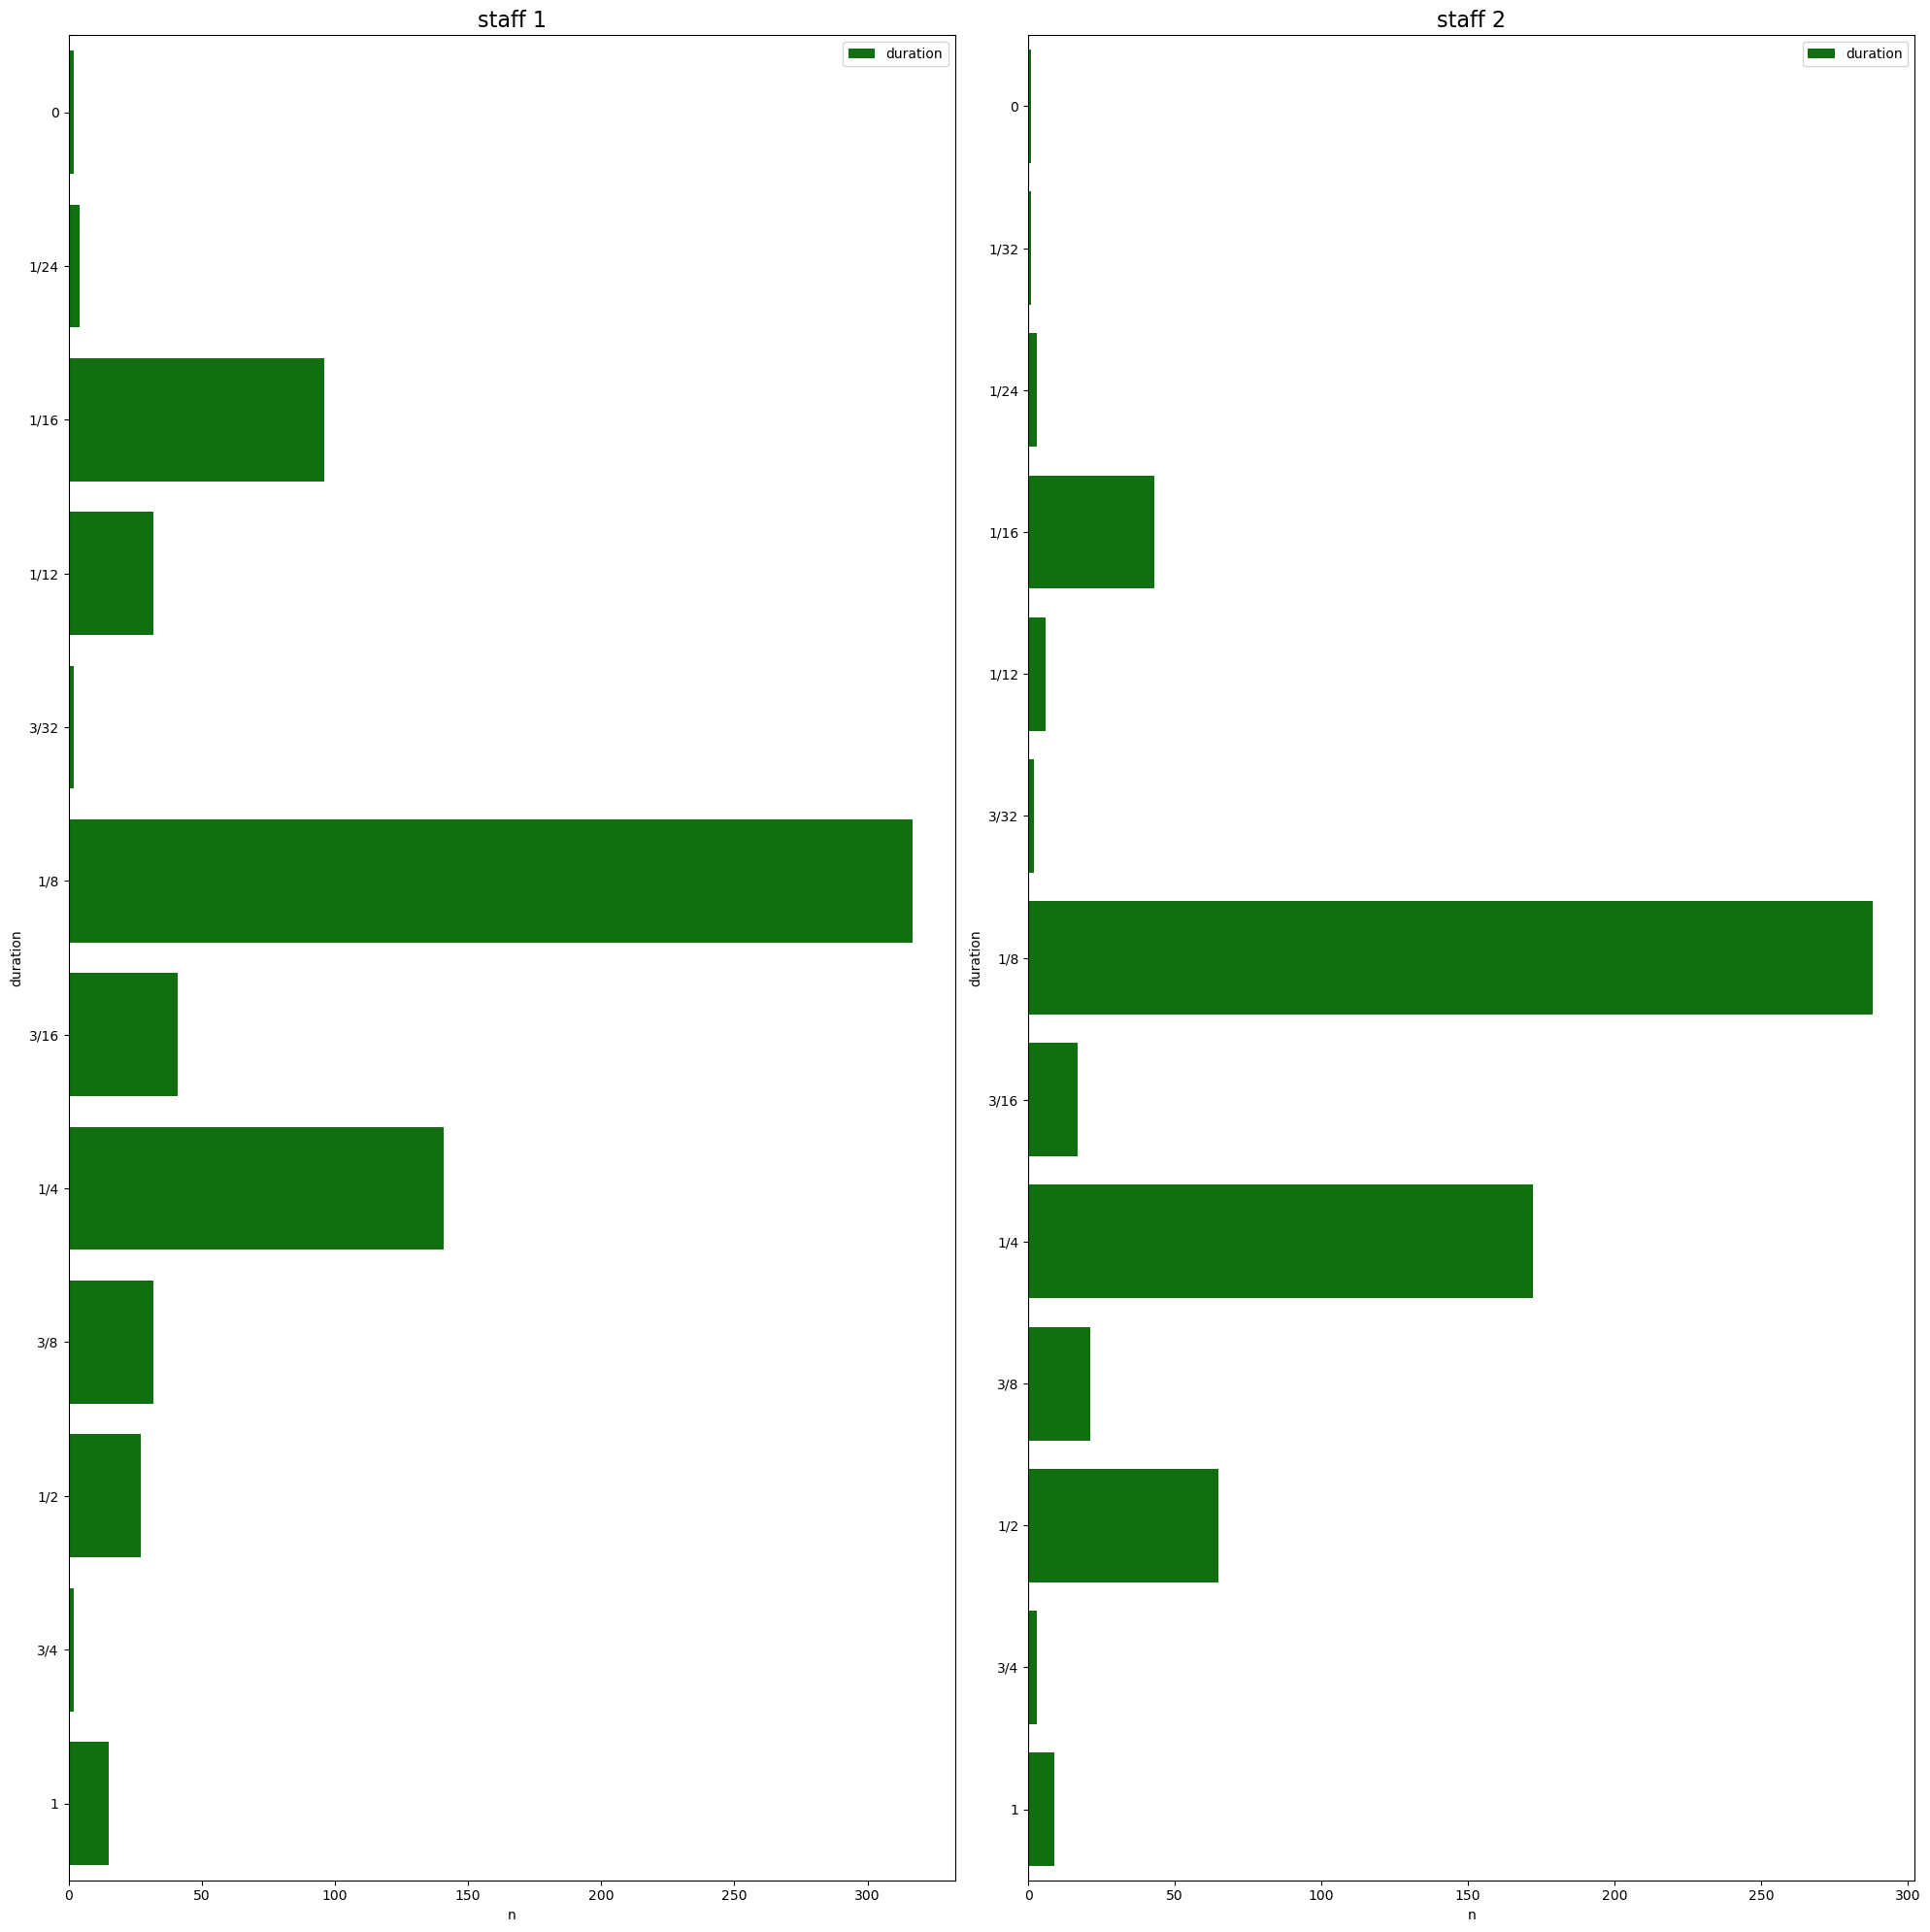

In [29]:
column_names = sorted(mn_onset_count.staff.unique().tolist())

columnas = 2
renglones = math.ceil(len(column_names) / columnas)

fig, axes = plt.subplots(nrows = renglones, ncols = columnas, figsize=(20, 20))
##fig.suptitle("Histogram of 'Duration' for Notes by Staves", fontsize = 16)

i = 0
j = 0

for col in column_names:
    sns.barplot(data = mn_onset_count[mn_onset_count.staff == col], x = 'n_note_count'
                 , y = 'duration',
                 label = 'duration',
                 ax = axes[i],  color='green')
    
    subplot_title = "staff " + str(col)

    axes[i].set_title(subplot_title, size = 16)
    axes[i].set(xlabel="n")
    axes[i].legend()
    
    i += 1

fig.tight_layout()  

Se puede concluir hasta aquí que los tiempos binarios son predominantes mientras que hay unos pocos ternarios y que las duraciones bajas no son comunes.

### Estadísticas de las duraciones de los silencios
Para un trabajo posterior a desarrollar, resulta de interés el obtener las duraciones de los silencios existentes en las rebanadas de $n$-notas.

In [30]:
from fractions import Fraction

mn_onset_rest_count = pd.DataFrame(columns=['filename', 'part',
                                  'staff', 'duration', 'rest_count'])

from fractions import Fraction

parts_notes_rests = s.mscx.notes_and_rests()

for part, staves in parts_staves:
    ## Filter staves for one part at a time
    part_notes_rests = parts_notes_rests[parts_notes_rests['staff'].isin(staves)]

    ## Rests are also counted, but we only want to see the notes held
    part_notes_rests = part_notes_rests[pd.isna(part_notes_rests.midi)]

    mn_onsets = part_notes_rests.groupby(by = ['staff', 'duration'])

    for key, row in mn_onsets.count().iterrows():
        mn_onset_rest_count.loc[len(mn_onset_rest_count.index)] = [filename, part, key[0], key[1], row.mn]

In [31]:
mn_onset_rest_count.to_csv('.\\data\\mn_onset_rest_count.csv')

In [32]:
mn_onset_rest_count = pd.read_csv('.\\data\\mn_onset_rest_count.csv', index_col = 0)

In [33]:
mn_onset_rest_count

,filename,part,staff,duration,rest_count
0,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,1/16,1
1,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,1/8,12
2,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,1/4,1
3,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,1/2,2
4,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,1/16,2
5,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,1/8,15
6,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,1/4,9
7,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,3/8,1
8,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,7/16,1
9,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,1/2,6


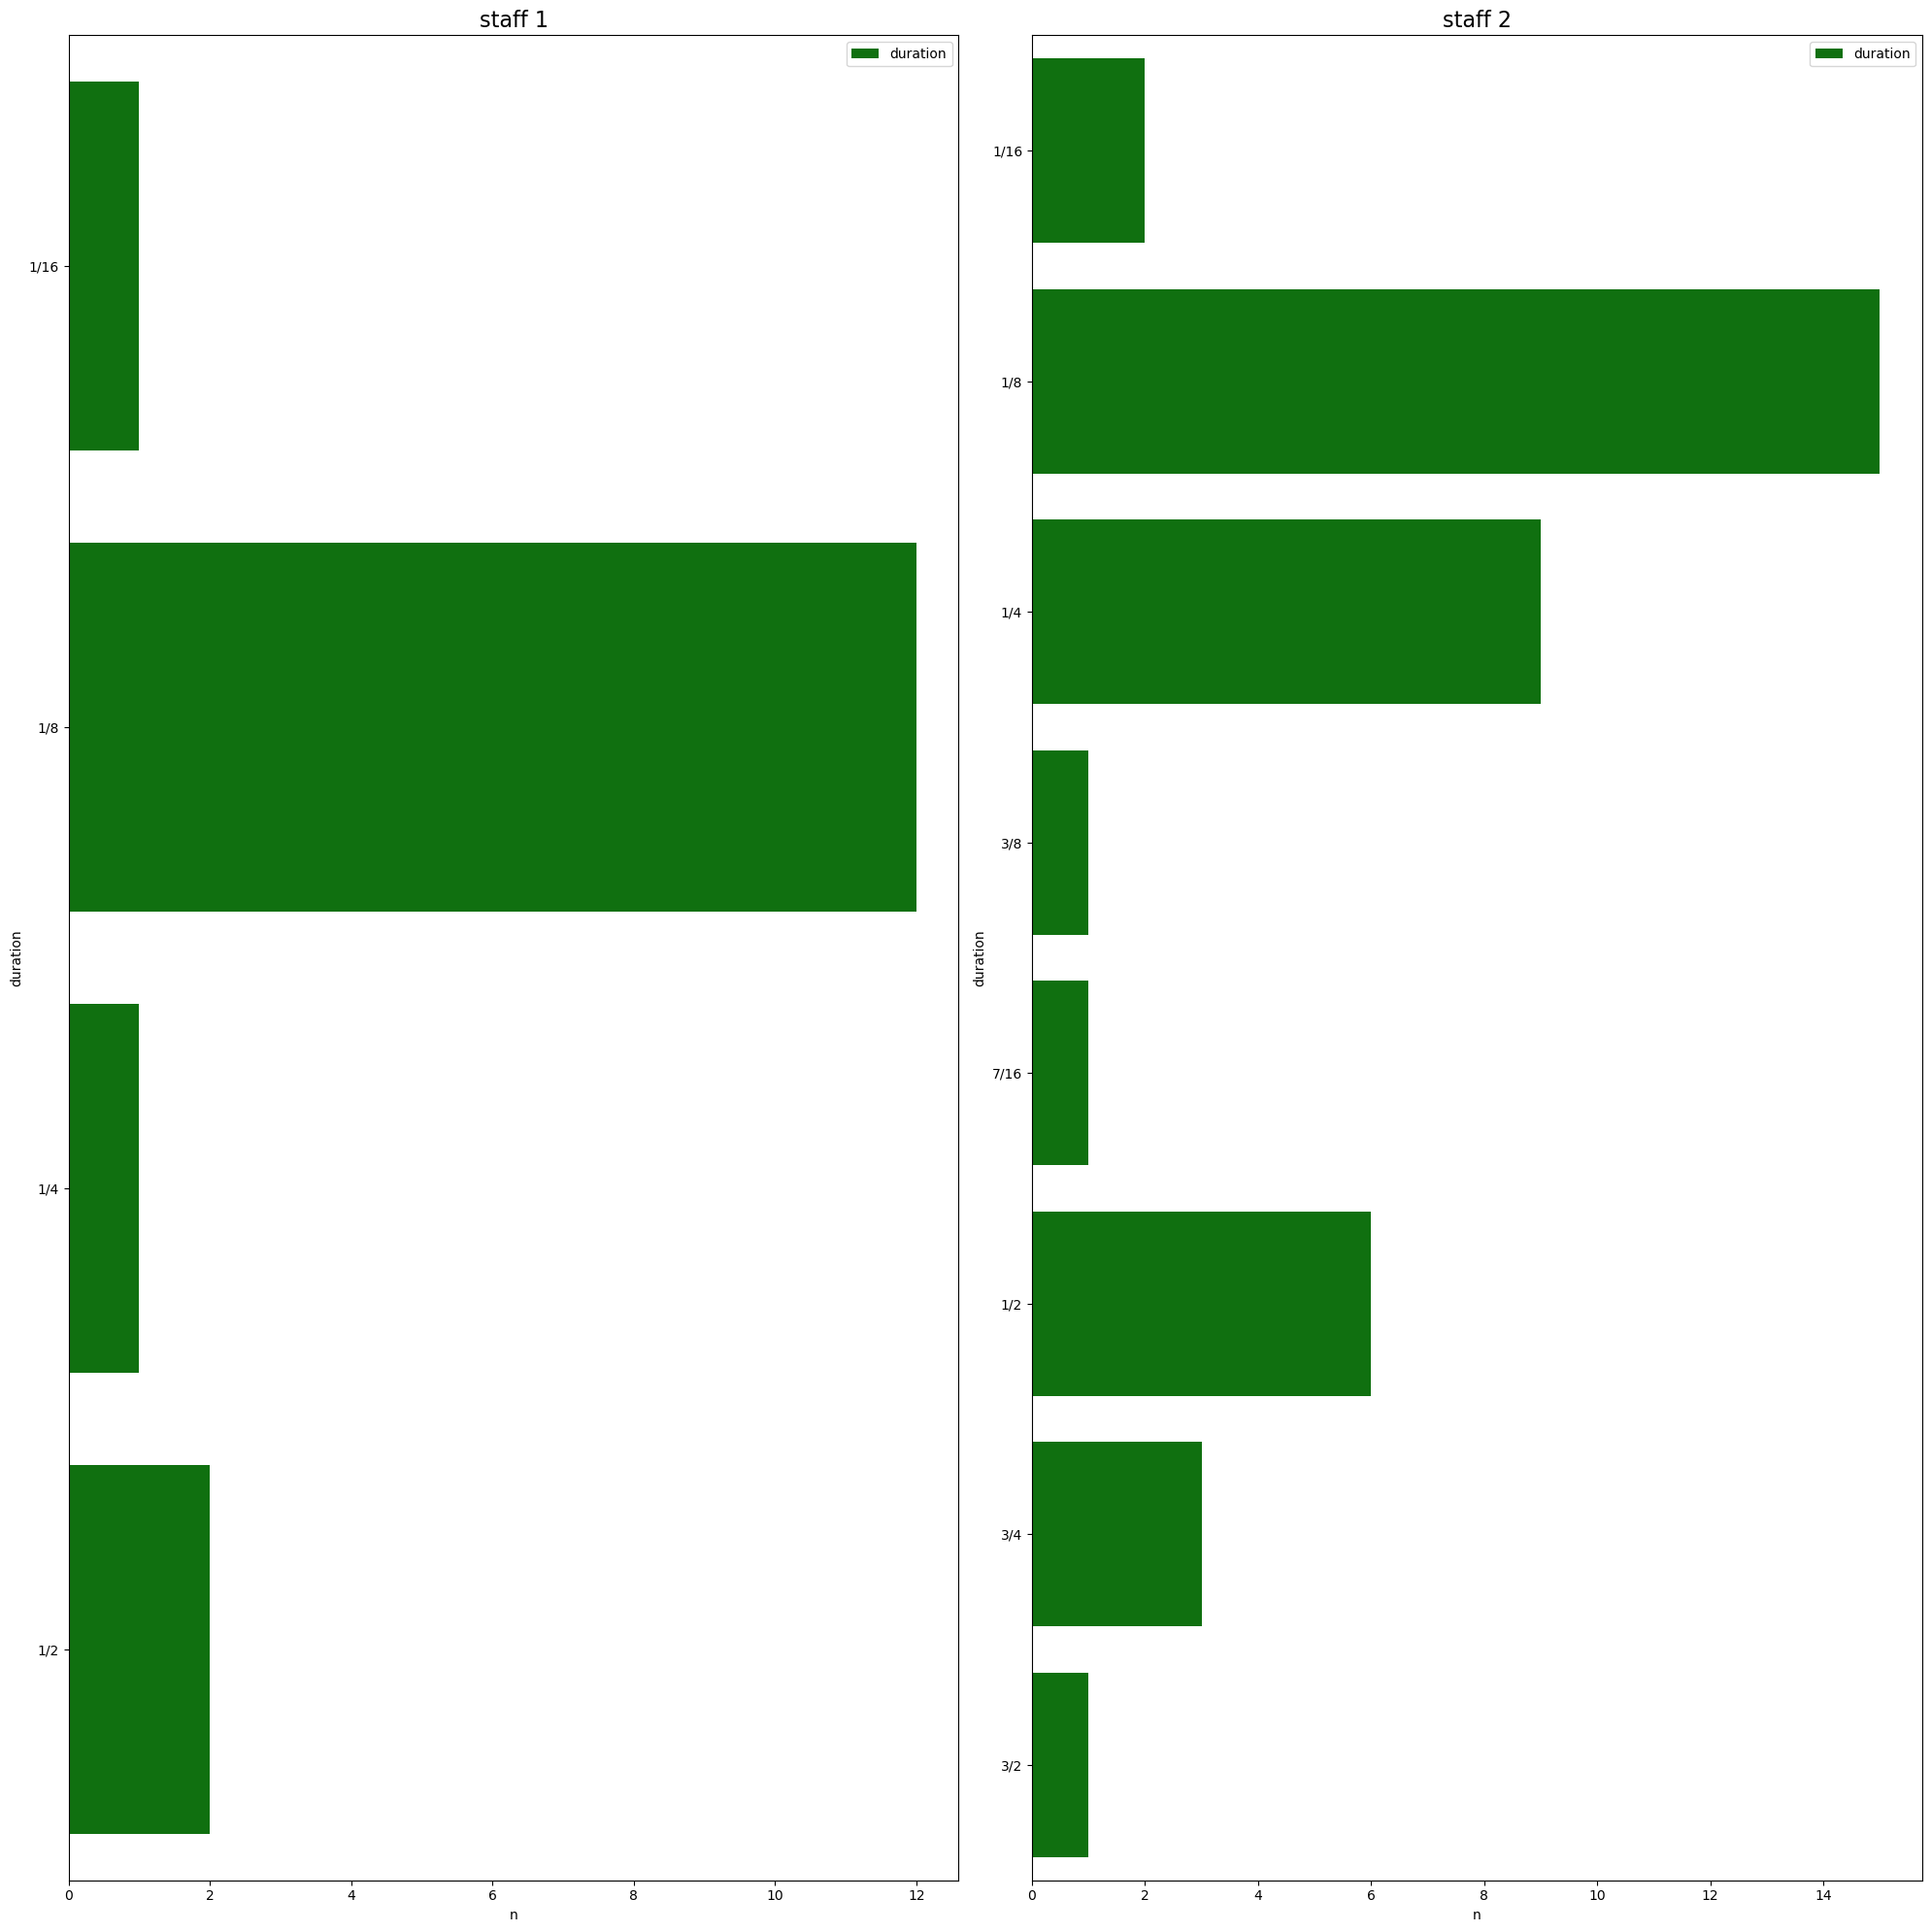

In [35]:
column_names = sorted(mn_onset_rest_count.staff.unique().tolist())

columnas = 2
renglones = math.ceil(len(column_names) / columnas)

fig, axes = plt.subplots(nrows = renglones, ncols = columnas, figsize=(20, 20))
##fig.suptitle("Histograma duración", fontsize = 16)

i = 0
j = 0

for col in column_names:
    sns.barplot(data = mn_onset_rest_count[mn_onset_rest_count.staff == col], x = 'rest_count'
                 , y = 'duration',
                 label = 'duration',
                 ##ax = axes[i][j], 
                 ax = axes[i],  color='green')

    subplot_title = "staff " + str(col)

    axes[i].set_title(subplot_title, size = 16)
    axes[i].set(xlabel="n")
    axes[i].legend()
    
    i += 1

fig.tight_layout()  

Se puede concluir hasta aquí que los tiempos binarios son predominantes mientras que hay unos pocos ternarios. En general hay pocos silencios en la partitura.

### Estadística de los diferentes tiempos para notas que ocurrieron en la misma rebanada de tiempo.
En el siguiente análisis se pretendió identificar la conveniencia de establecer la duración de cada nota en un pentagrama específico a partir de una distribución de probabilidad o a partir de la cantidad de notas en la rebanada de tiempo. En este caso tenemos que cada nota puede tener su propio tiempo por rebanada. A modo de curiosidad propondré que cada nota defina su duración mediante una distribución de probabilidad asociada al pentagrama.

In [36]:
## Aquí se recupera la parte del instrumento piano y los pentagramas
## Las partes sorresponden a instrumentos diferentes con sus pentagramas
parts_staves = []
for part in s.mscx.metadata['parts']:
    ## Filtramos sólo aquellas partes de piano
    if s.mscx.metadata['parts'][part]['instrument'] == 'Piano':
        ## Cada parte puede tener uno o más pentagramas. El piano regularmente tendrá 2. 
        ##   El que está en la clave de SOL (mano derecha) y el que está en clave de FA (mano izquerda)
        staves = s.mscx.metadata['parts'][part]['staves']
        parts_staves.append([part, staves])
        print("Nombre de la parte de 'Piano':", part, ". Id's de pentagramas:", staves)

## En este dataframe vamos a acumular el conteo de notas pulsadas al mismo tiempo por cada rebanada de tiempo
n_notes_and_duration = pd.DataFrame(columns=['filename', 'part', 'staff', 'time_signature', 'mc', 
                                             'mc_onset', 'duration', 'count_n_notes'])
max_midi = 0

parts_notes_rests = s.mscx.notes_and_rests()

for part, staves in parts_staves:
    ## Filtra los pentagramas de una parte cada vez
    part_notes_rests = parts_notes_rests[parts_notes_rests['staff'].isin(staves)]

    ## Los silencios igual se cuentan, pero sólo queremos ver las notas pulsadas
    part_notes_rests = part_notes_rests[part_notes_rests.midi > 0]
    
    ## Agrupamos por rebanada de tiempo en cada compás en cada pentagrama
    slices_n_notes = part_notes_rests.groupby(by=["mc", "mc_onset", "staff", "timesig", "duration"])
    
    ## Iteramos y almacenamos el conteo de n-notas por cada rebanada de tiempo y por pentagrama
    for key, row in slices_n_notes.count().iterrows():
        n_notes_and_duration.loc[len(n_notes_and_duration.index)] = [filename, part, key[2], key[3], key[0], key[1], key[4], row.mn]

Nombre de la parte de 'Piano': part_1 . Id's de pentagramas: [1]
Nombre de la parte de 'Piano': part_2 . Id's de pentagramas: [2]


In [37]:
n_notes_and_duration.sort_values(by=['mc', 'mc_onset', 'staff', 'duration']).head(50)

,filename,part,staff,time_signature,mc,mc_onset,duration,count_n_notes
0,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,1,0,1/8,1
1,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,1,1/8,1/8,2
516,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,4/4,1,1/8,1/8,1
517,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,4/4,1,1/8,1/4,1
2,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,1,1/4,1/8,2
518,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,4/4,1,1/4,1/8,1
3,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,2,0,1/4,2
4,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_1,1,4/4,2,0,3/8,1
519,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,4/4,2,0,1/2,2
520,Keith_Jarrett_-_Danny_Boy__Londonderry_Air__To...,part_2,2,4/4,2,1/8,3/8,1


# Referencias

* Briot, J. (2021). From artificial neural networks to deep learning for music generation: history, concepts and trends. *Neural Comput & Applic 33*, 36-65.
* Ijas, A. H. (2 de Noviembre de 2019). *Build a simple predictive keyboard using python and Keras*. Obtenido de medium.com: https://medium.com/analytics-vidhya/build-a-simple-predictive-keyboard-using-python-and-keras-b78d3c88cffb
* Lozano Cruz, O. S.-G. (6 de Junio de 2013). El cerebro y la música. *Rev Med UV, Enero - Junio 2013*, págs. 17-22.
* Morán Martínez, M. C. (1 de Noviembre de 2009). Psicología y Música: inteligencia musical y desarrollo estético*. *Revista Digital Universitaria*, págs. 1-13.

